## Why do we want to use HSV rather than RGB for example for image segmentation?

The simplest answer for this question is that **you can separate colours much easier with HSV than with RGB**.

But, what does this even mean?

HSV gives us:
- Hue = Actual colour information, e.g., red, green, blue... On the other hand, RGB shows us colours as mixtures of Red, Green, Blue channels
- Saturation = How vivid or intense the colour is
- Values = Brightness of the pixel

For example, if you want to segment out all the red objects in an image, it's much easier to do so in HSV space because all the red pixels will have similar hue values.

Check out the figure below.
- x-axis: Hue[0, 180]
- y-axis: Saturation[0,255]
- Value is 255 in this graph

In [4]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from scipy.ndimage import median_filter
from skimage.color import rgb2hsv
import os
from typing import Dict

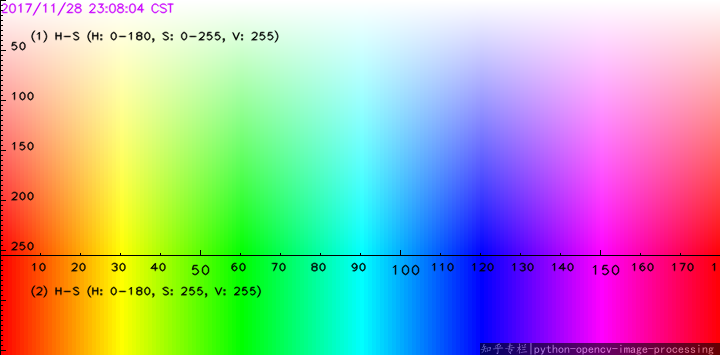

In [ ]:
Image(filename='../data/hsv_color.png')

To clarify my point, I'll segment strawberries from a fruits image.

This process can be easily done without using U-Net or other kinds of CNN.

# Image Segmentation of Strawberries

### This is the original image

height x width x RGB (647, 1036, 3)


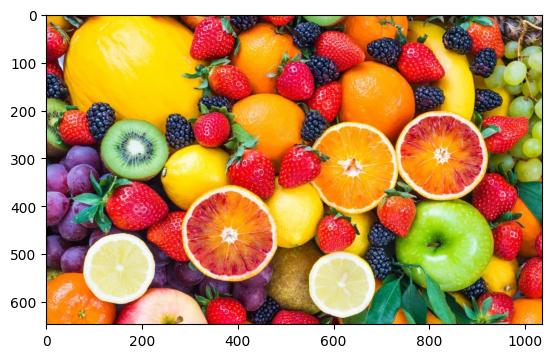

In [ ]:
img = io.imread('../data/fruits.png')
print(f"height x width x RGB {img.shape}")
plt.imshow(img)

### Plot Hue, Saturation, Value of the original image

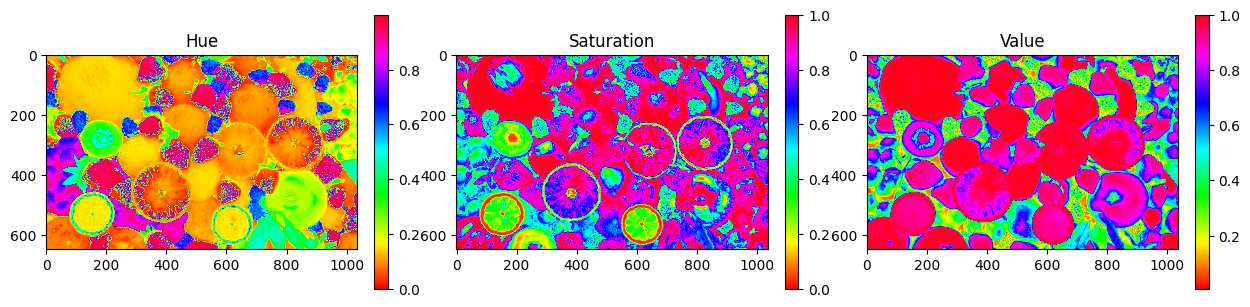

In [ ]:
# show hsv
fruits = io.imread('../data/fruits.png')
fruits_hsv = rgb2hsv(fruits)
fig, ax = plt.subplots(1, 3, figsize=(15,12))
im = ax[0].imshow(fruits_hsv[:,:,0], cmap='hsv')
ax[0].set_title('Hue')
fig.colorbar(im, ax=ax[0], fraction=0.04)

im = ax[1].imshow(fruits_hsv[:,:,1], cmap='hsv')
ax[1].set_title('Saturation')
fig.colorbar(im, ax=ax[1], fraction=0.04)

im = ax[2].imshow(fruits_hsv[:,:,2], cmap='hsv')
ax[2].set_title('Value')
fig.colorbar(im, ax=ax[2], fraction=0.04)

### Segment Strawberries
- 1. Create masks (e.g., **mask for Hue** and/or **mask for Saturation** and/or **mask for Value**)
- 2. Combine the masks as a median_filter
- 3. Apply the filter

Text(0.5, 1.0, 'Segmented Image')

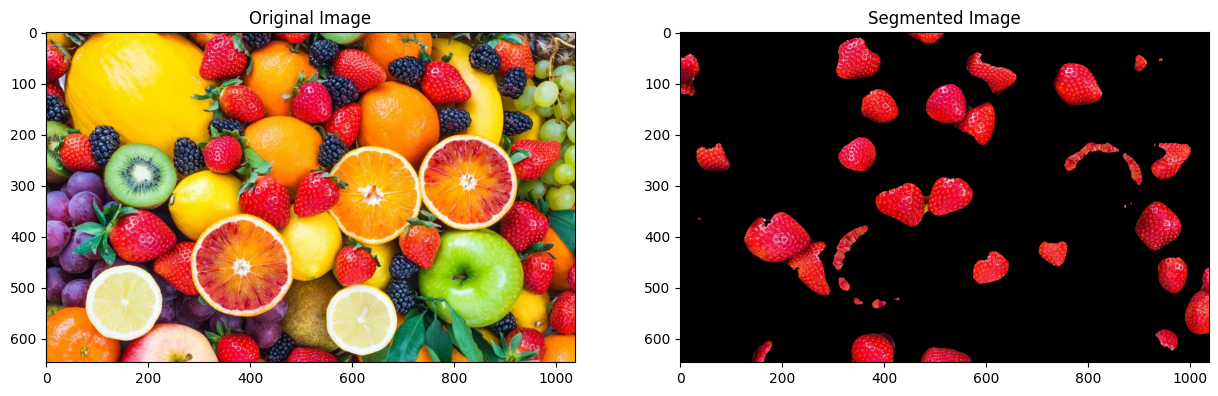

In [ ]:
fruits = io.imread('../data/fruits.png')
fruits_hsv = rgb2hsv(fruits)
fig, ax = plt.subplots(1, 2, figsize=(15,12))
# create hsv mask
lower_hmask = fruits_hsv[:,:,0] > 0.9
upper_hmask = fruits_hsv[:,:,0] < 0.03
smask= fruits_hsv[:,:,1] > 0.7
mask_1 = median_filter((lower_hmask+upper_hmask)*smask, size = 25)

# segment RGB image
red = fruits[:,:,0]*mask_1
green = fruits[:,:,1]*mask_1
blue = fruits[:,:,2]*mask_1
strawberry_masked = np.dstack((red,green,blue))

ax[0].imshow(fruits)
ax[0].set_title('Original Image')
ax[1].imshow(strawberry_masked)
ax[1].set_title('Segmented Image')

As you can see, other fruits except for strawberries are flagged out. But, you still see some edges of grapefruits. If you configure mask values accurately, you can remove the edges. From the next part, we'll see if we can apply the same image segmentation methods for satellite images.

# Flag out clouds

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#! ls
%cd drive/MyDrive/MachineLearning
%cd Geospatial_ML
! ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
data_exploration  evaluation   models	    prepare_data    README.md
docs		  experiments  poetry.lock  pyproject.toml  requirements.txt


### Load data

In [3]:
data_directory = "../data_colab/256_200"

y_train  = np.load(os.path.join(data_directory, '2022_06_20.npz'))['y_mask']
x_train  = np.load(os.path.join(data_directory, '2022_06_20.npz'))['x_input']

### Define functions to get RGB and HSV images

In [5]:
def convert_rgb_uint(image: np.ndarray)->np.ndarray:
  rgb = image[...,:3]
  # RGB
  red = image[:,:,0].astype(np.uint8)
  green = image[:,:,1].astype(np.uint8)
  blue = image[:,:,2].astype(np.uint8)
  original = np.dstack((red,green,blue))
  return original

def generate_rgb_hsv(image:np.ndarray)->Dict[str, np.ndarray]:
  rgb = convert_rgb_uint(image)
  hsv = rgb2hsv(rgb)
  return {
      "rgb": rgb,
      "hue": hsv[...,0],
      "saturation":hsv[...,1],
      "value":hsv[...,2]
  }

### Take training image 3 as an example

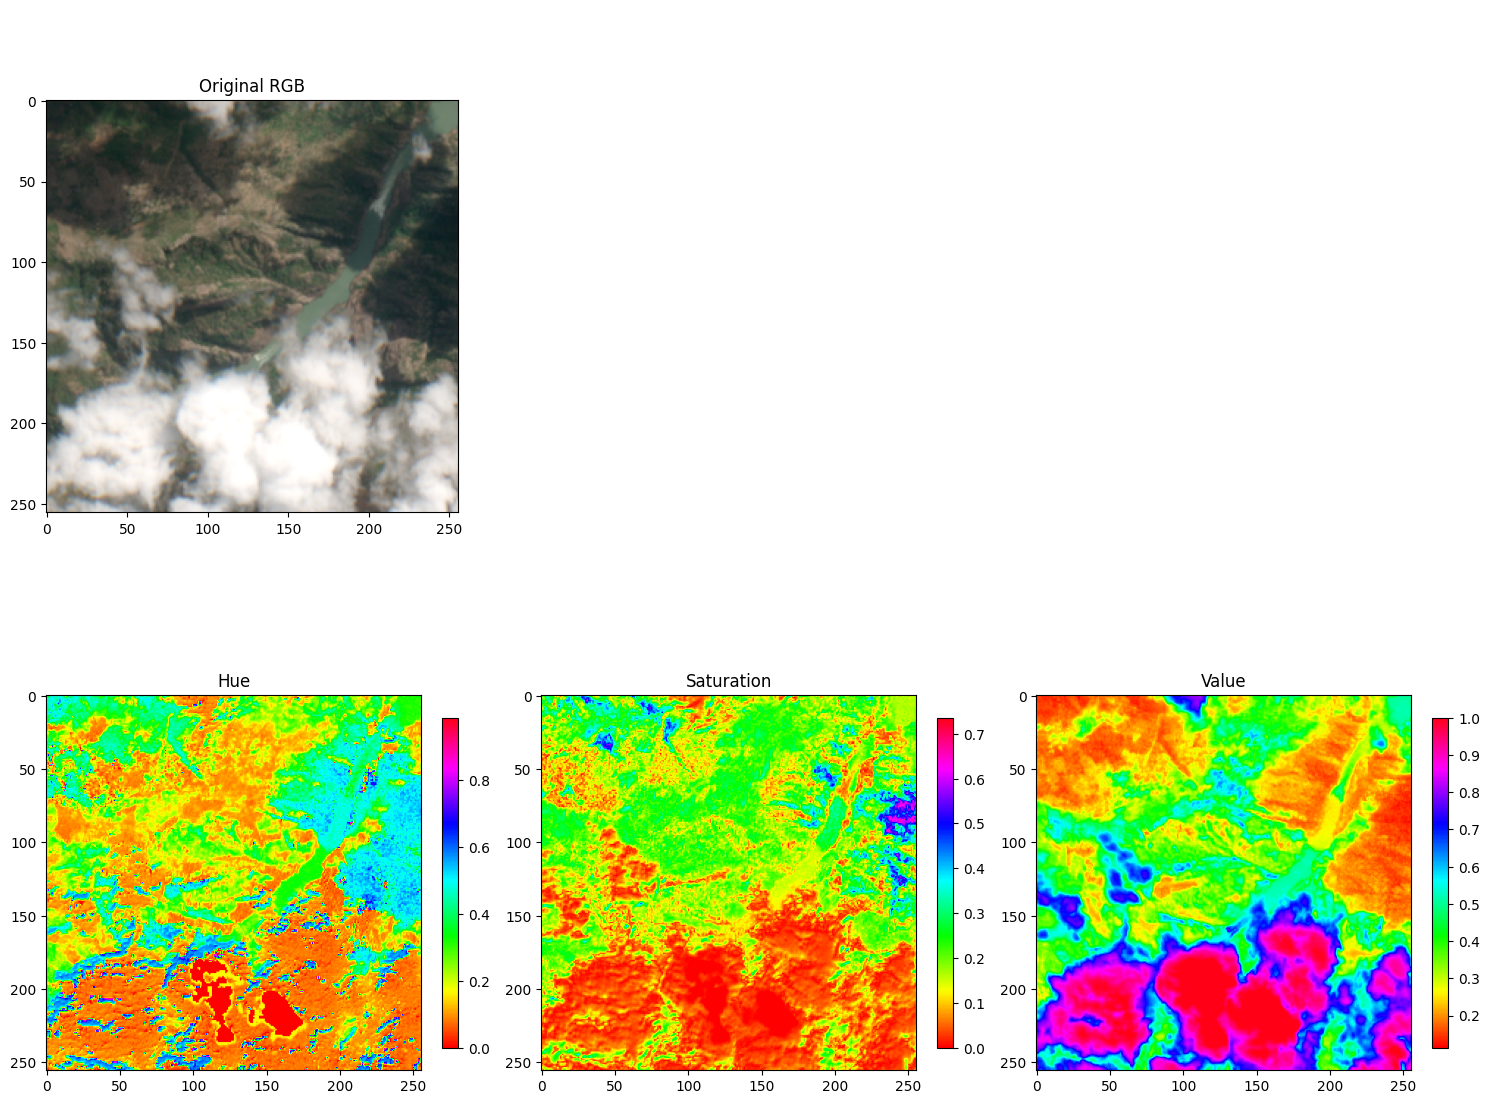

In [14]:
images = generate_rgb_hsv(x_train[2][...,:3])
rgb = images['rgb']
hue = images['hue']
saturation = images['saturation']
value = images['value']

fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(15,12))

# Plot the first image on the first column of the first row
ax[0, 0].imshow(rgb)
ax[0, 0].set_title('Original RGB')

# Plot the remaining three images on the second row
im = ax[1, 0].imshow(hue, cmap='hsv')
ax[1, 0].set_title('Hue')
fig.colorbar(im, ax=ax[1, 0], fraction=0.04)

im = ax[1, 1].imshow(saturation, cmap='hsv')
ax[1, 1].set_title('Saturation')
fig.colorbar(im, ax=ax[1, 1], fraction=0.04)

im = ax[1, 2].imshow(value, cmap='hsv')
ax[1, 2].set_title('Value')
fig.colorbar(im, ax=ax[1, 2], fraction=0.04)

# Remove the empty images from the first row
ax[0, 1].axis('off')
ax[0, 2].axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### Flag out clouds

Based on hue and saturation, I'll create a mask (generate_masked_image) to flag out clouds.

In [15]:
def generate_masked_image(image:np.ndarray)->np.ndarray:
  images = generate_rgb_hsv(image)
  rgb = images['rgb']
  hue = images['hue']
  saturation = images['saturation']
  # create masks
  hmask = hue < 0.35
  smask = saturation > 0.1
  meadian_mask = median_filter(hmask*smask, size = 25)
  # apply a mask

  masked_red = rgb[...,0]*meadian_mask
  masked_green = rgb[...,1]*meadian_mask
  masked_blue = rgb[...,2]*meadian_mask
  masked_image = np.dstack((masked_red,masked_green,masked_blue))
  return masked_image

### Compare RGB, Flagged out clouds and True Mask

Text(0.5, 1.0, 'True Mask')

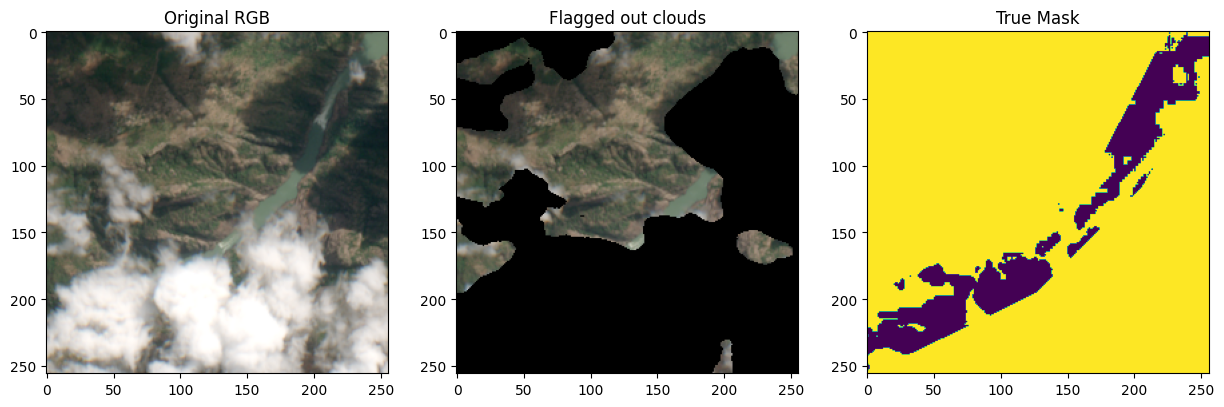

In [19]:
original = convert_rgb_uint(x_train[2][...,:3])
masked_image = generate_masked_image(x_train[2][...,:3])
true_mask = y_train[2]
fig, ax = plt.subplots(1, 3, figsize=(15,12))
ax[0].imshow(original)
ax[0].set_title('Original RGB')
ax[1].imshow(masked_image)
ax[1].set_title('Flagged out clouds')
ax[2].imshow(true_mask)
ax[2].set_title('True Mask')

Text(0.5, 1.0, 'Clud Flagged out Image')

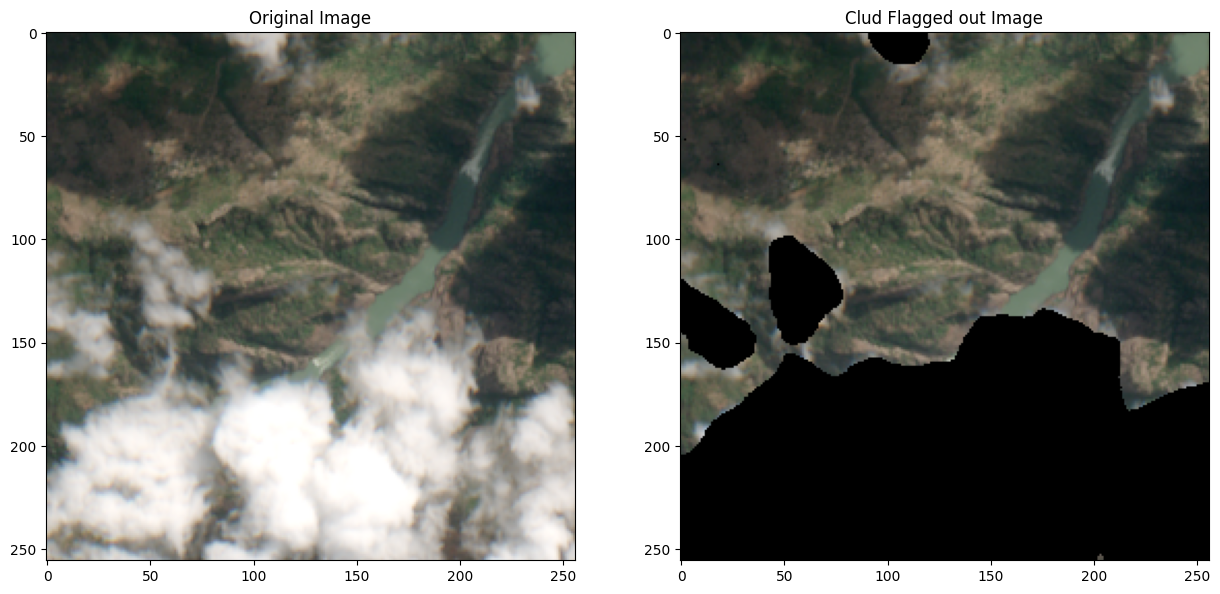

In [ ]:
satellite = x_train[2][...,:3]
satellite_hsv = rgb2hsv(satellite)
fig, ax = plt.subplots(1, 2, figsize=(15,12))
# create hsv mask
lower_hmask = satellite_hsv[:,:,0] > 0.3
upper_hmask = satellite_hsv[:,:,0] < 0.8
smask = satellite_hsv[:,:,1] > 0.1
vmask = satellite_hsv[:,:,2] <140
mask_1 = median_filter((lower_hmask+upper_hmask)*smask*vmask, size = 25)

# RGB
red = satellite[:,:,0].astype(np.uint8)
green = satellite[:,:,1].astype(np.uint8)
blue = satellite[:,:,2].astype(np.uint8)
original = np.dstack((red,green,blue))
# segment RGB image
masked_red = red*mask_1
masked_green = green*mask_1
masked_blue = blue*mask_1
satellite_masked = np.dstack((masked_red,masked_green,masked_blue))

ax[0].imshow(original)
ax[0].set_title('Original Image')
ax[1].imshow(satellite_masked)
ax[1].set_title('Clud Flagged out Image')

In [ ]:
def generate_hsv_images(images:np.ndarray):
  for image in images:
    image = image[...,:3]
    image_hsv = rgb2hsv(image)
    fig, ax = plt.subplots(1, 3, figsize=(15,12))
    im = ax[0].imshow(image_hsv[:,:,0], cmap='hsv')
    ax[0].set_title('Hue')
    fig.colorbar(im, ax=ax[0], fraction=0.04)

    im = ax[1].imshow(image_hsv[:,:,1], cmap='hsv')
    ax[1].set_title('Saturation')
    fig.colorbar(im, ax=ax[1], fraction=0.04)

    im = ax[2].imshow(image_hsv[:,:,2], cmap='hsv')
    ax[2].set_title('Value')
    fig.colorbar(im, ax=ax[2], fraction=0.04)


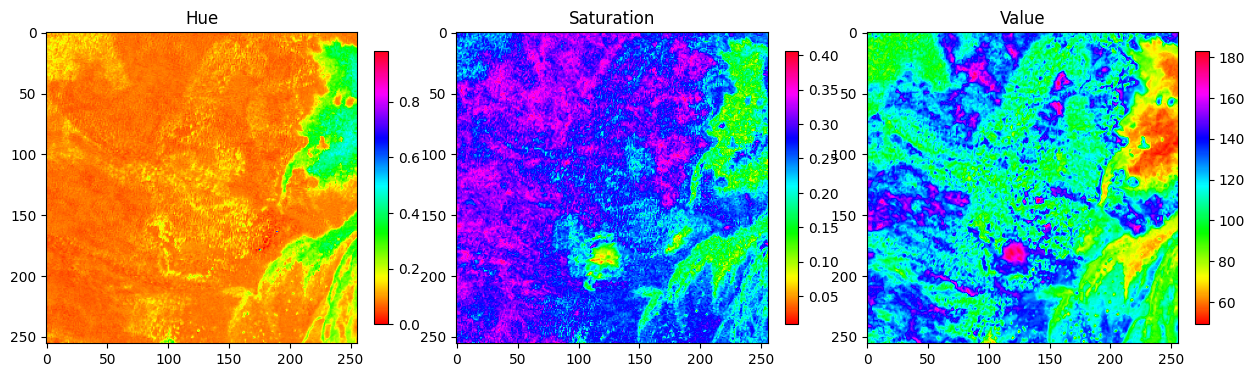

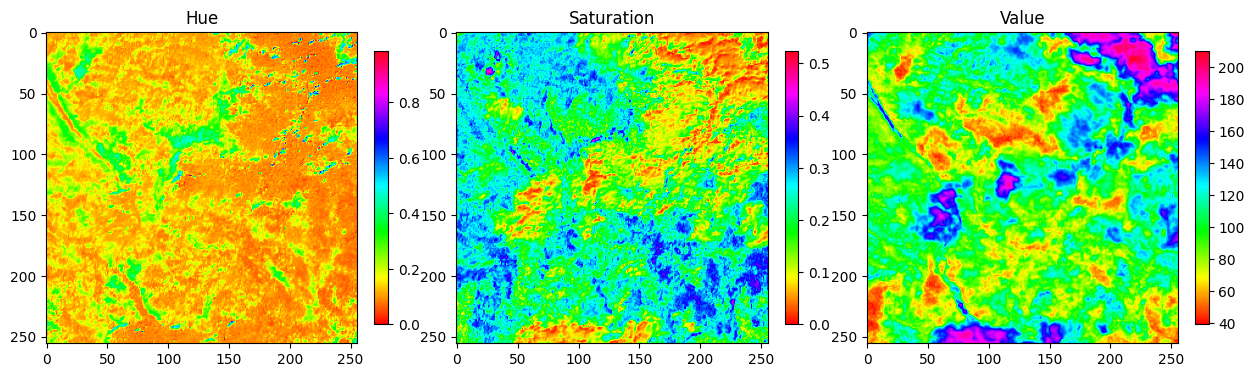

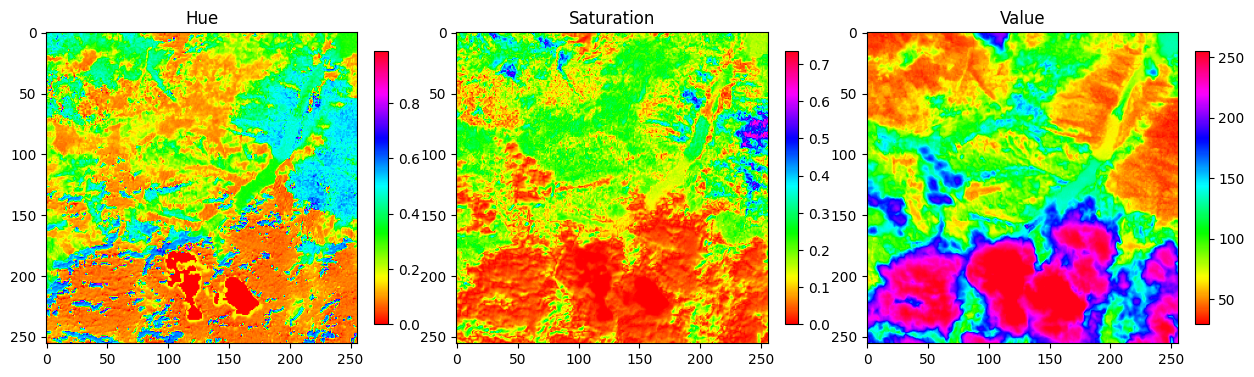

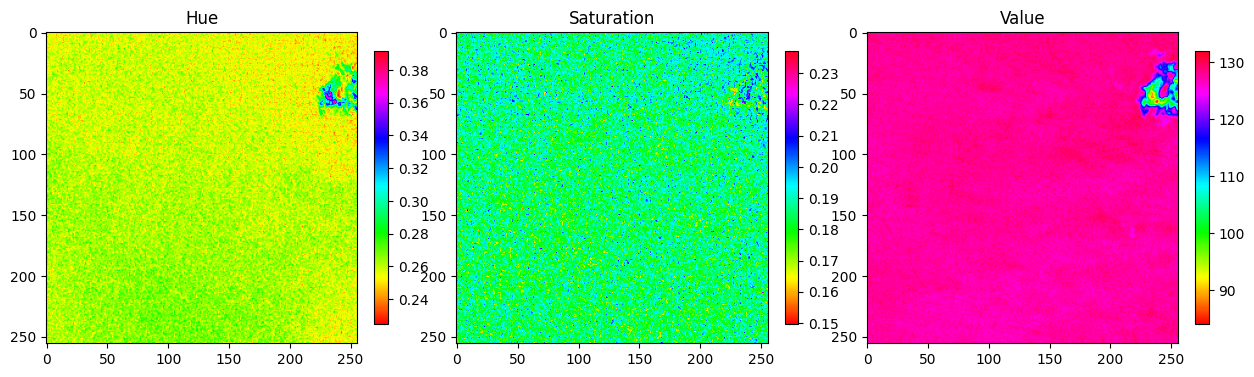

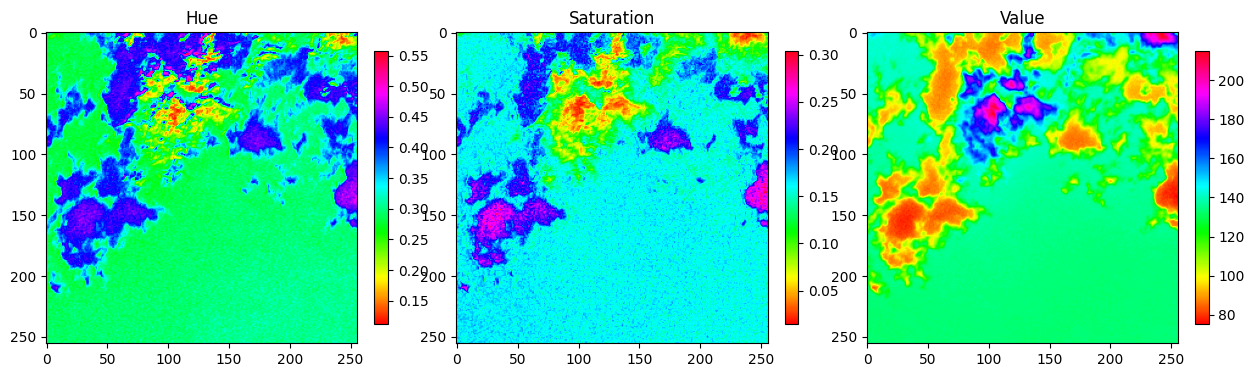

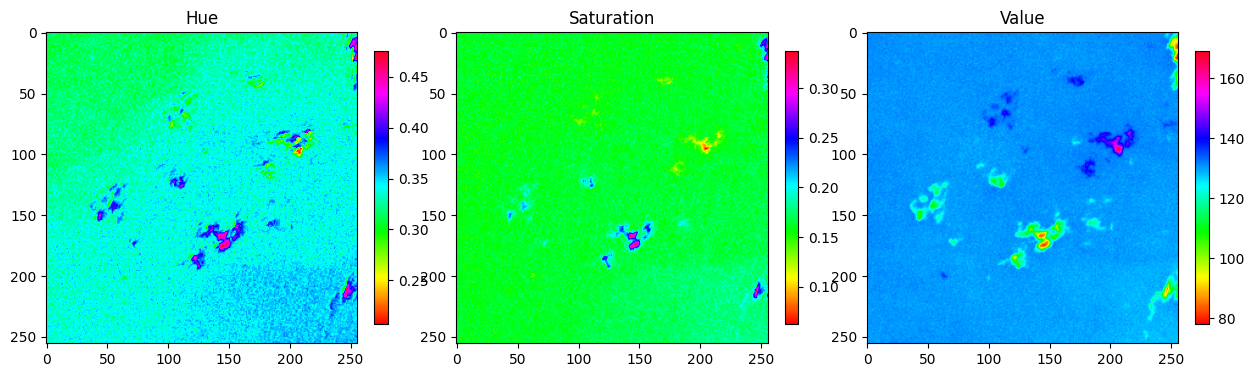

In [ ]:
generate_hsv_images(x_train[:6])

In [ ]:
def generate_cloud_flagged_out(images:np.ndarray):
  for image in images:
    image = image[...,:3]
    image_hsv = rgb2hsv(image)
    fig, ax = plt.subplots(1, 2, figsize=(15,12))
    hmask = image_hsv[:,:,0] < 0.35
    smask = image_hsv[:,:,1] > 0.1
    mask_1 = median_filter(hmask*smask, size = 25)

    # RGB
    red = image[:,:,0].astype(np.uint8)
    green = image[:,:,1].astype(np.uint8)
    blue = image[:,:,2].astype(np.uint8)
    original = np.dstack((red,green,blue))
    # segment RGB image
    masked_red = red*mask_1
    masked_green = green*mask_1
    masked_blue = blue*mask_1
    image_masked = np.dstack((masked_red,masked_green,masked_blue))

    ax[0].imshow(original)
    ax[0].set_title('Original Image')
    ax[1].imshow(image_masked)
    ax[1].set_title('Cloud Flagged out Image')

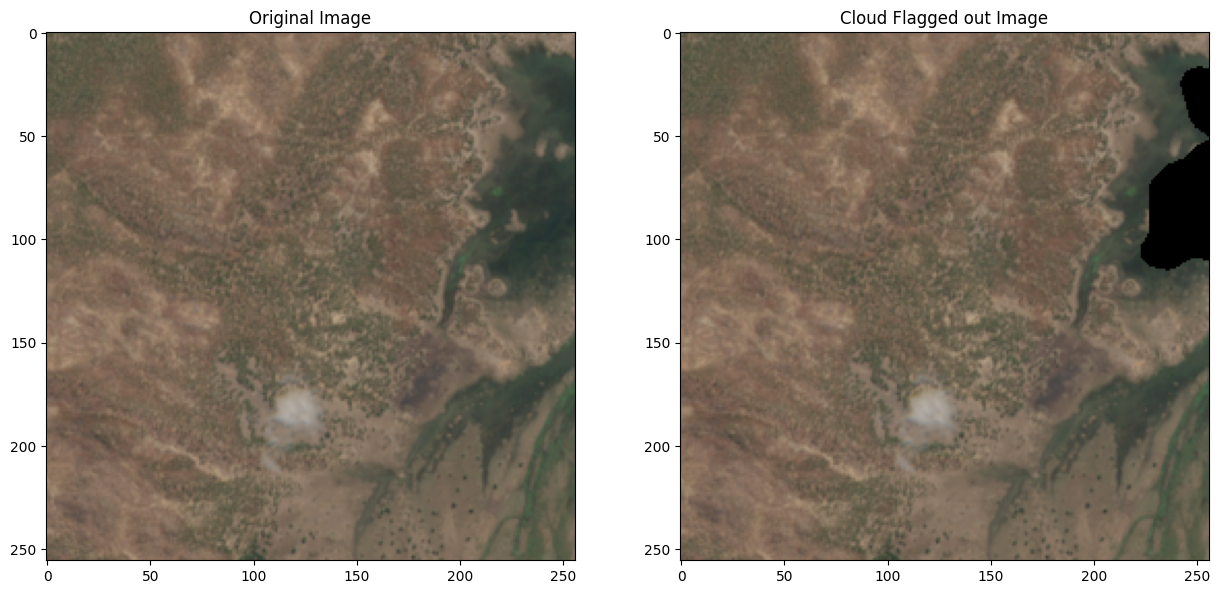

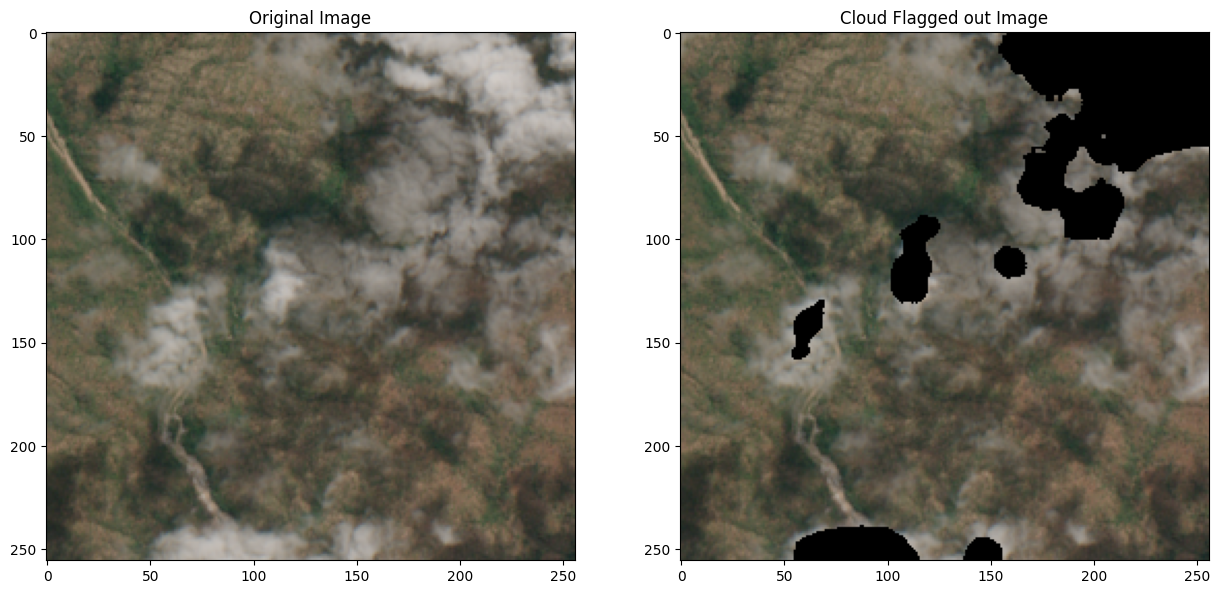

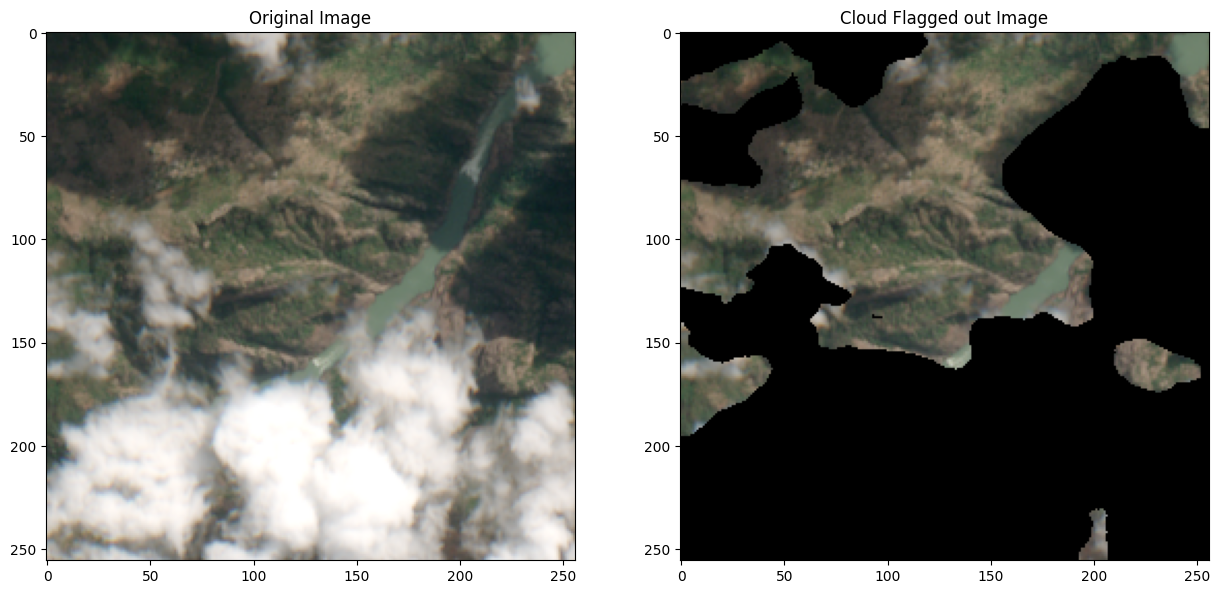

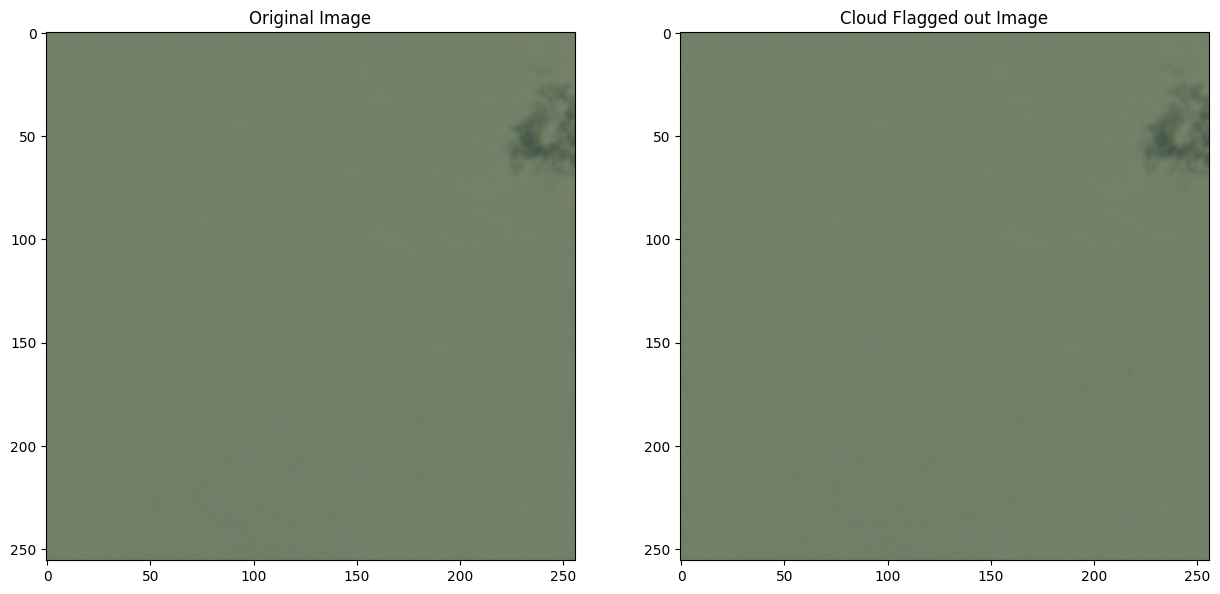

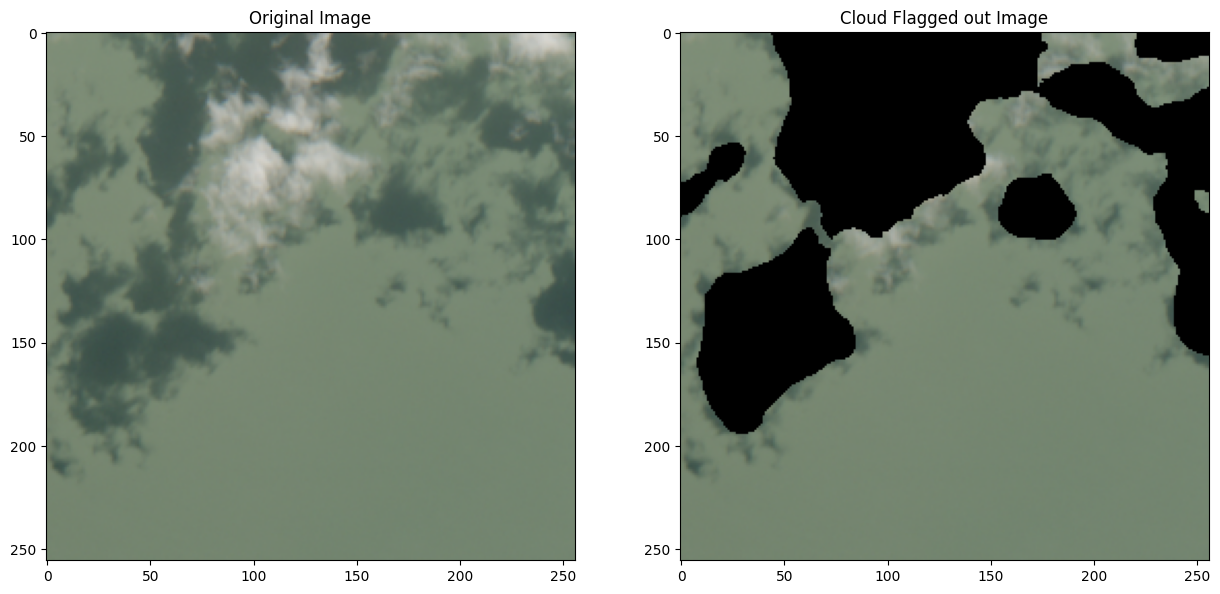

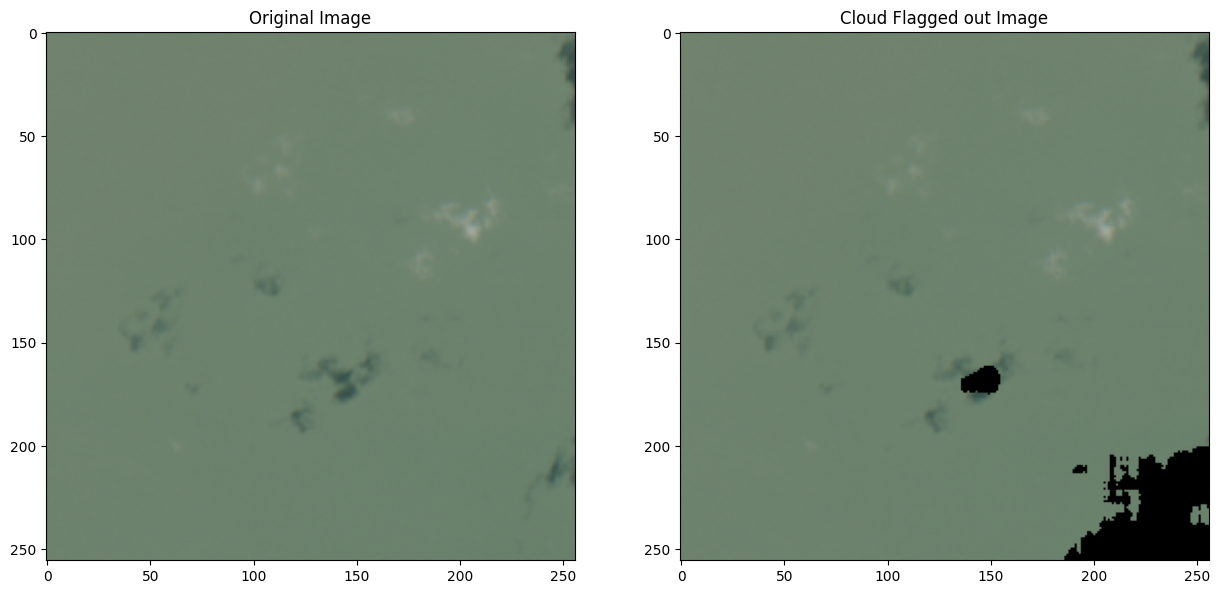

In [ ]:
generate_cloud_flagged_out(x_train[:6])